In [2]:
import plotly.express as px
import pandas as pd

## Read the data of UK Travellers to Abroad 

In [3]:
# read data
df = pd.read_csv('./data/UK_Travellers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.head()

,Month,Travellers
0,1980-01-01,823
1,1980-02-01,780
2,1980-03-01,1058
3,1980-04-01,1397
4,1980-05-01,1438


## Read Data and Plot for trend

In [4]:
# def a plot fucntion

def plot_travellers(
        df:pd.DataFrame,
        y_col: str,
        y_lable: str,
        lam=None) -> None:
    
    fig = px.line(df, x='Month', y=y_col, labels={'Month': 'Month', y_col:y_lable})
    fig.update_layout(template='simple_white', title_text='UK Travellers Abroad',
                      width=1200, height=400)
    if lam is not None:
        fig.add_annotation(
            text=f"λ = {lam:.3f}",
            align='left', yanchor='bottom', showarrow=False,
            font=dict(size=20, color="black", family="Courier New, monospace"),
            bordercolor='black', borderwidth=2, bgcolor="white"
        )
    
    return fig.show()

In [5]:
# plot the travellers data and show trend
plot_travellers(df, y_col='Travellers', y_lable='Travellers Amount')

In [6]:
# AS can be shown in the above
# UK government announced lockdown in March 2020
# So only data before Dec 2019 will be analysed

df_traveller = df.iloc[:480].copy()
plot_travellers(df=df_traveller, y_col='Travellers', y_lable='Travellers Amount')

In [7]:
# Visually the data isn't stationary
# test with Augmented Dickey-Fuller

from statsmodels.tsa.stattools import adfuller
def test_adf(ds:pd.Series) -> None:
    test_result = adfuller(ds)
    print('ADF Statistic: ', test_result[0])
    print('P-Value: ', test_result[1])
    print('Critical Values:')
    for thres, adf_stat in test_result[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))

# before stablisation, the stats are
test_adf(df_traveller['Travellers'])

ADF Statistic:  0.05034577397065155
P-Value:  0.9625028252469451
Critical Values:
	1%: -3.44
	5%: -2.87
	10%: -2.57


In [8]:
# stable variance by box-cox
from scipy.stats import boxcox

df_traveller['Travellers_box_cox'], lam = boxcox(df_traveller['Travellers'])
plot_travellers(df=df_traveller, y_col='Travellers_box_cox', y_lable='Travellers Amount after Box Cox', lam=lam)

df_traveller['Travellers_boxcox_diff'] = df_traveller['Travellers_box_cox'].diff()

plot_travellers(df=df_traveller, y_col='Travellers_boxcox_diff', y_lable='Travellers Amount after Box Cox and diff') 
test_adf(df_traveller['Travellers_boxcox_diff'][1:])


ADF Statistic:  -5.842311232284776
P-Value:  3.752492729872892e-07
Critical Values:
	1%: -3.44
	5%: -2.87
	10%: -2.57


## Now data is stationary and ready for futher modelling

### Lag determination

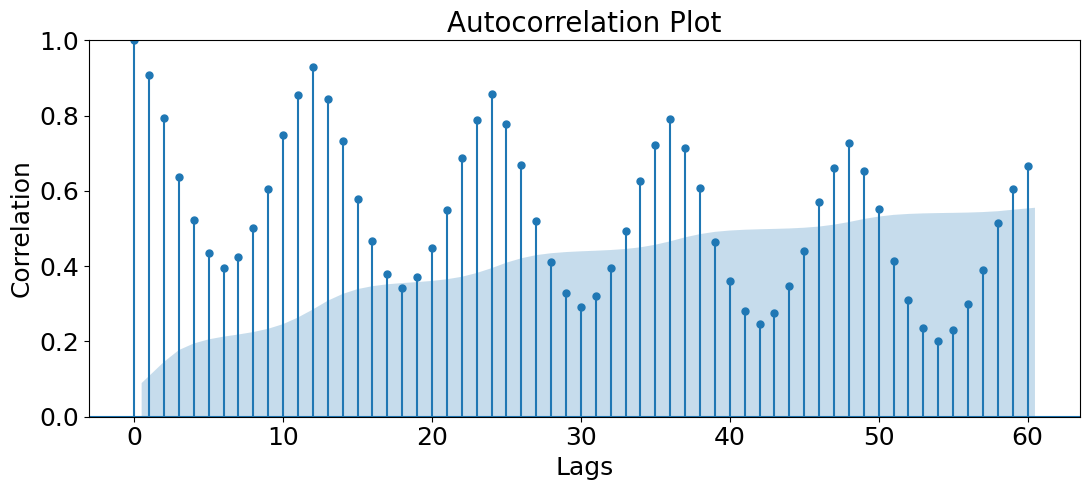

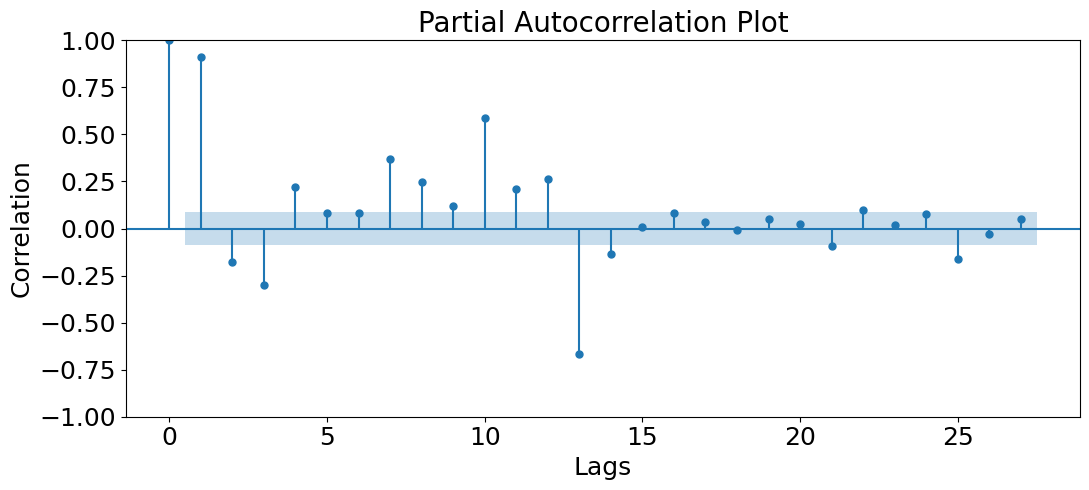

In [9]:
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


# plot the ACF to find which lags are statistically significant
plt.rc("figure", figsize=(11,5))
plot_acf(df_traveller['Travellers'], lags=60)
plt.ylim(0,1)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

# plot the PACF to find which lags are statistically significant
plt.rc("figure", figsize=(11, 5))
plot_pacf(df_traveller['Travellers'], method="ywm")
plt.xlabel("Lags", fontsize=18)
plt.ylabel("Correlation", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Partial Autocorrelation Plot", fontsize=20)
plt.tight_layout()
plt.show()

### Autoregression

In [10]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# split train and test
train = df_traveller.iloc[1:-int(len(df_traveller) * 0.2)]
test = df_traveller.iloc[-int(len(df_traveller) * 0.2):]

# build ar model
selector = ar_select_order(train['Travellers_boxcox_diff'], 15)
model_ag = AutoReg(train['Travellers_boxcox_diff'], lags=selector.ar_lags).fit()

In [11]:
from scipy.special import inv_boxcox
import plotly.graph_objects as go

# Get forecasts and convert to actual passenger volumes
transformed_forecasts = list(model_ag.forecast(steps=len(test)))
boxcox_forecasts_ag = []
for idx in range(len(test)):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['Travellers_box_cox'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts_ag[idx-1]

    boxcox_forecasts_ag.append(boxcox_forecast)

forecasts = inv_boxcox(boxcox_forecasts_ag, lam)


def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Month'], y=train['Travellers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Month'], y=test['Travellers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Month'], y=forecasts, name='Forecast', line=go.scatter.Line(color='gray', dash='dot')))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=1200, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'Autoregression')

### ARIMA

<Figure size 1100x500 with 0 Axes>

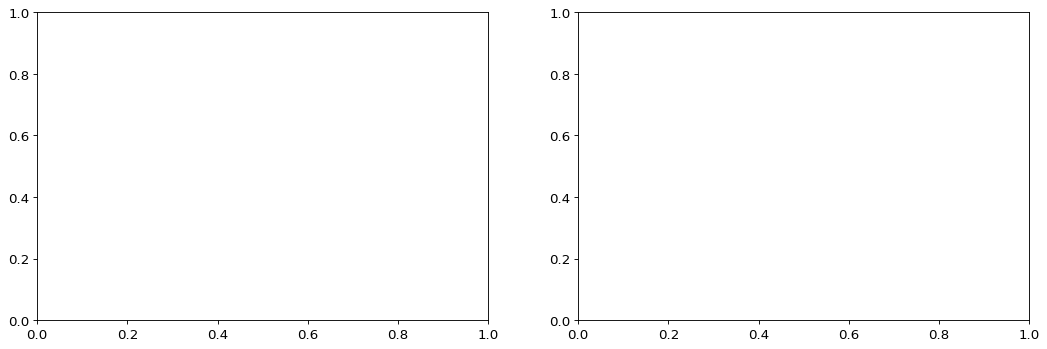

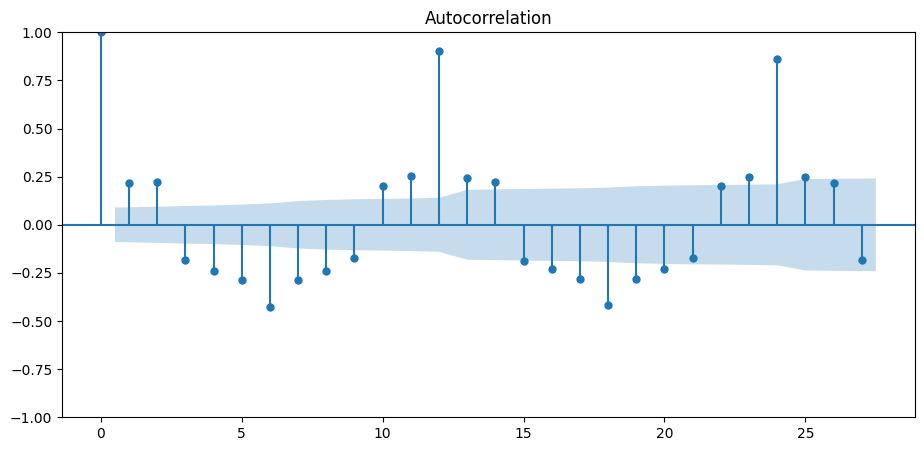

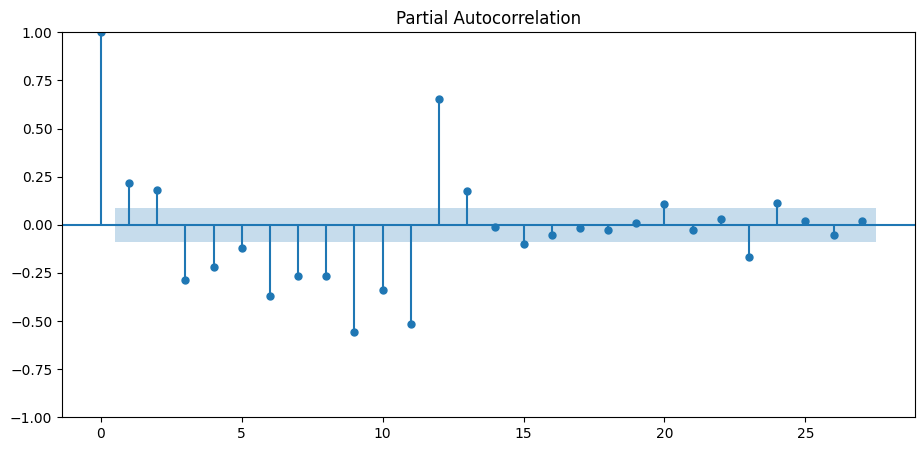

In [12]:
# Plot acf and pacf
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
plot_acf(df_traveller['Travellers_boxcox_diff'][1:])
plot_pacf(df_traveller['Travellers_boxcox_diff'][1:], method='ywm')
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

In [14]:
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(train['Travellers_box_cox'], order=(13,1,13)).fit()
boxcox_forecasts_arima = model_arima.forecast(len(test))
forecasts_arima = inv_boxcox(boxcox_forecasts_arima, lam)
plot_forecasts(forecasts_arima, 'ARIMA')

d:\github\UK-Traveller-Analysis\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

d:\github\UK-Traveller-Analysis\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

